In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
from PIL import Image
import warnings
import time
from typing import Dict, List, Tuple, Optional, Union
import glob
import json
import logging
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from io import BytesIO, StringIO

# ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score, 
                           roc_curve, auc, confusion_matrix, precision_recall_curve,
                           f1_score, precision_score, recall_score, balanced_accuracy_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from scipy import stats
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Optional imports
try:
    import umap
    UMAP_AVAILABLE = True
    print(" UMAP available")
except ImportError:
    UMAP_AVAILABLE = False
    print(" UMAP not available")

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    TF_AVAILABLE = True
    print("TensorFlow available")
except ImportError:
    TF_AVAILABLE = False
    print(" TensorFlow not available")

# Suppress warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

 UMAP available
TensorFlow available
All libraries imported successfully!


In [3]:
class Config:
    """Enhanced configuration with balanced classification parameters"""
    
    # Base paths 
    BASE_PATH = Path('./pipeline')  
    OUTPUT_BASE = Path('./output')
    
    HOLE_SIZES = ['20mm', '25mm', '30mm', '40mm']
    
    # Data formats
    EXPECTED_COLUMNS = ['nodenumber', 'x-coordinate', 'y-coordinate', 'temperature']
    
    # Image processing
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    IMG_CHANNELS = 3
    SUPPORTED_IMG_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    
    # Model parameters
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001
    PATIENCE = 10
    
    # BALANCED CLASSIFICATION PARAMETERS
    # Lower thresholds for better balance
    TEMPERATURE_THRESHOLD = 305  # Reduced from 310
    SPATIAL_ZONES = 20
    ROLLING_WINDOW = 5
    
    # Balance control
    TARGET_LEAK_RATIO = 0.4  # Target 40% leak samples
    MIN_LEAK_RATIO = 0.2     # Minimum 20% leak samples
    MAX_LEAK_RATIO = 0.6     # Maximum 60% leak samples
    
    # Classification sensitivity
    SENSITIVITY_LEVEL = 'balanced'  # 'strict', 'balanced', 'sensitive'
    
    # Output paths
    OUTPUT_DIR = OUTPUT_BASE
    MODEL_DIR = OUTPUT_DIR / 'models'
    PLOTS_DIR = OUTPUT_DIR / 'plots'
    DATA_DIR = OUTPUT_DIR / 'processed_data'

# Create output directories
def setup_directories():
    """Setup all required directories"""
    for dir_path in [Config.OUTPUT_DIR, Config.MODEL_DIR, Config.PLOTS_DIR, Config.DATA_DIR]:
        dir_path.mkdir(parents=True, exist_ok=True)
    return True

setup_directories()
print(f"Output directories created in: {Config.OUTPUT_DIR}")
print(f"Looking for data in: {Config.BASE_PATH}")
print(f"Target leak ratio: {Config.TARGET_LEAK_RATIO:.1%}")

Output directories created in: output
Looking for data in: pipeline
Target leak ratio: 40.0%


In [6]:
class BalancedDataLoader:
    """Enhanced data loader with balanced leak classification"""
    
    @staticmethod
    def discover_data_files():
        """Discover all data files with pattern recognition"""
        print(" Discovering data files...")
        discovered_files = {}
        
        for hole_size in Config.HOLE_SIZES:
            hole_path = Config.BASE_PATH / hole_size
            discovered_files[hole_size] = {
                'data_files': [],
                'image_files': [],
                'file_count': 0,
                'image_count': 0
            }
            
            if hole_path.exists():
                print(f"   Found directory: {hole_path}")
                # Find data files
                all_files = list(hole_path.iterdir())
                data_files = []
                
                for file in all_files:
                    if file.is_file():
                        file_name = file.name.lower()
                        
                        # Skip hidden files and known non-data files
                        if file_name.startswith('.'):
                            continue
                            
                        # Check if it's likely a data file
                        if (hole_size.replace('mm', '') in file_name or 
                            'test' in file_name or 
                            any(char.isdigit() for char in file_name)):
                            data_files.append(file)
                
                discovered_files[hole_size]['data_files'] = data_files
                discovered_files[hole_size]['file_count'] = len(data_files)
                print(f"     Found {len(data_files)} data files")
                
                # Find image files
                contours_path = hole_path / 'contours'
                if contours_path.exists():
                    image_files = []
                    for ext in Config.SUPPORTED_IMG_FORMATS:
                        image_files.extend(list(contours_path.glob(f'*{ext}')))
                        image_files.extend(list(contours_path.glob(f'*{ext.upper()}')))
                    
                    discovered_files[hole_size]['image_files'] = image_files
                    discovered_files[hole_size]['image_count'] = len(image_files)
                    print(f" Found {len(image_files)} image files")
        
        total_files = sum([data['file_count'] for data in discovered_files.values()])
        total_images = sum([data['image_count'] for data in discovered_files.values()])
        print(f"\n Discovery complete: {total_files} data files, {total_images} images")
        
        return discovered_files
    
    @staticmethod
    def parse_data_file(file_path: Path) -> pd.DataFrame:
        """Parse data file with advanced format detection"""
        try:
            # Try different parsing methods
            parsing_methods = [
                lambda: pd.read_csv(file_path, sep=',', header=None),
                lambda: pd.read_csv(file_path, sep='\s+', header=None),
                lambda: pd.read_csv(file_path, sep='\t', header=None),
                lambda: pd.read_csv(file_path, sep=None, engine='python', header=None),
            ]
            
            df = None
            for method in parsing_methods:
                try:
                    df = method()
                    if len(df.columns) >= 4 and len(df) > 0:
                        break
                except:
                    continue
            
            if df is None or df.empty:
                return pd.DataFrame()
            
            # Assign column names
            if len(df.columns) >= 4:
                df.columns = Config.EXPECTED_COLUMNS[:len(df.columns)]
                
                if len(df.columns) > 4:
                    additional_cols = [f'feature_{i}' for i in range(4, len(df.columns))]
                    df.columns = Config.EXPECTED_COLUMNS + additional_cols
            
            # Data cleaning
            df = df.dropna()
            
            # Ensure numeric columns
            numeric_columns = ['x-coordinate', 'y-coordinate', 'temperature']
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            df = df.dropna()
            
            # Validate temperature values (more lenient)
            if 'temperature' in df.columns:
                df = df[(df['temperature'] > 250) & (df['temperature'] < 1000)]
            
            return df
            
        except Exception as e:
            print(f"⚠️ Could not parse {file_path.name}: {e}")
            return pd.DataFrame()
    
    @staticmethod
    def balanced_leak_classification(df: pd.DataFrame, hole_size: str, file_idx: int = 0) -> Dict:
        """BALANCED leak classification with multiple strategies"""
        if df.empty or 'temperature' not in df.columns:
            return {'leak_status': 0, 'confidence': 0.0, 'criteria_met': [], 'method': 'empty'}
        
        temp_stats = {
            'mean': df['temperature'].mean(),
            'max': df['temperature'].max(),
            'min': df['temperature'].min(),
            'std': df['temperature'].std(),
            'q75': df['temperature'].quantile(0.75),
            'q90': df['temperature'].quantile(0.90),
            'q95': df['temperature'].quantile(0.95),
        }
        
        # Hole size factors (more aggressive for larger holes)
        hole_factors = {'20mm': 0.8, '25mm': 1.0, '30mm': 1.2, '40mm': 1.5}
        factor = hole_factors.get(hole_size, 1.0)
        
        # STRATEGY 1: Statistical outlier method
        z_scores = np.abs(stats.zscore(df['temperature']))
        outlier_count = np.sum(z_scores > 2)  # Points beyond 2 standard deviations
        outlier_ratio = outlier_count / len(df)
        
        # STRATEGY 2: Temperature threshold method (relaxed)
        base_threshold = Config.TEMPERATURE_THRESHOLD * factor
        high_temp_count = np.sum(df['temperature'] > base_threshold)
        high_temp_ratio = high_temp_count / len(df)
        
        # STRATEGY 3: Temperature range method
        temp_range = temp_stats['max'] - temp_stats['min']
        high_range = temp_range > (20 * factor)
        
        # STRATEGY 4: Percentile method
        high_percentile = temp_stats['q90'] > (base_threshold - 5)
        
        # STRATEGY 5: File-based method (simulate different leak conditions)
        # Create variation based on hole size and file index
        file_factor = (file_idx % 3 + 1) * 0.3  # Varies from 0.3 to 0.9
        
        # Multiple classification criteria
        criteria = {}
        criteria_met = []
        
        # Criterion 1: Statistical outliers
        criteria['outliers'] = outlier_ratio > 0.1 * factor
        if criteria['outliers']:
            criteria_met.append(f"Outlier ratio ({outlier_ratio:.1%}) significant")
        
        # Criterion 2: High temperature ratio
        criteria['high_temp_ratio'] = high_temp_ratio > 0.15 * factor
        if criteria['high_temp_ratio']:
            criteria_met.append(f"High temp ratio ({high_temp_ratio:.1%}) > threshold")
        
        # Criterion 3: Mean temperature
        mean_threshold = base_threshold - 3  # More lenient
        criteria['mean_temp'] = temp_stats['mean'] > mean_threshold
        if criteria['mean_temp']:
            criteria_met.append(f"Mean temp ({temp_stats['mean']:.1f}K) > {mean_threshold:.1f}K")
        
        # Criterion 4: Temperature variability
        std_threshold = 8 * factor  # Reduced threshold
        criteria['temp_variance'] = temp_stats['std'] > std_threshold
        if criteria['temp_variance']:
            criteria_met.append(f"Temp std ({temp_stats['std']:.1f}) > {std_threshold:.1f}")
        
        # Criterion 5: Maximum temperature
        max_threshold = base_threshold + (5 * factor)
        criteria['max_temp'] = temp_stats['max'] > max_threshold
        if criteria['max_temp']:
            criteria_met.append(f"Max temp ({temp_stats['max']:.1f}K) > {max_threshold:.1f}K")
        
        # Criterion 6: Spatial clustering (simplified)
        if 'x-coordinate' in df.columns and 'y-coordinate' in df.columns:
            high_temp_points = df[df['temperature'] > base_threshold]
            if len(high_temp_points) > 0:
                spatial_concentration = len(high_temp_points) / len(df)
                criteria['spatial_cluster'] = spatial_concentration > 0.1
                if criteria['spatial_cluster']:
                    criteria_met.append(f"Spatial clustering detected ({spatial_concentration:.1%})")
        
        # DECISION LOGIC - Multiple strategies
        criteria_count = sum(criteria.values())
        total_criteria = len(criteria)
        confidence = criteria_count / total_criteria
        
        # Strategy-based decision
        if Config.SENSITIVITY_LEVEL == 'strict':
            is_leak = criteria_count >= (total_criteria - 1)  # Need almost all criteria
        elif Config.SENSITIVITY_LEVEL == 'sensitive':
            is_leak = criteria_count >= 1  # Need at least one criterion
        else:  # 'balanced'
            is_leak = criteria_count >= (total_criteria // 2)  # Need at least half
        
        # Additional boost for larger holes
        if hole_size in ['30mm', '40mm'] and criteria_count >= 2:
            is_leak = True
            confidence = min(1.0, confidence + 0.2)
        
        # File index variation to create more diversity
        if file_idx % 4 == 0 and criteria_count >= 1:  # Every 4th file more likely to be leak
            is_leak = True
            confidence = min(1.0, confidence + 0.1)
        
        return {
            'leak_status': int(is_leak),
            'confidence': confidence,
            'criteria_met': criteria_met,
            'criteria_count': criteria_count,
            'method': f'balanced_{Config.SENSITIVITY_LEVEL}',
            'temp_stats': temp_stats,
            'strategies': {
                'outlier_ratio': outlier_ratio,
                'high_temp_ratio': high_temp_ratio,
                'temp_range': temp_range
            }
        }
    
    @staticmethod
    def balance_dataset(df: pd.DataFrame, target_ratio: float = None) -> pd.DataFrame:
        """Balance the dataset to achieve target leak ratio"""
        if df.empty or 'leak_status' not in df.columns:
            return df
        
        if target_ratio is None:
            target_ratio = Config.TARGET_LEAK_RATIO
        
        current_ratio = df['leak_status'].mean()
        print(f" Current leak ratio: {current_ratio:.1%}, Target: {target_ratio:.1%}")
        
        if abs(current_ratio - target_ratio) < 0.05:  # Already balanced
            print(" Dataset already balanced")
            return df
        
        leak_samples = df[df['leak_status'] == 1]
        no_leak_samples = df[df['leak_status'] == 0]
        
        total_samples = len(df)
        target_leak_count = int(total_samples * target_ratio)
        target_no_leak_count = total_samples - target_leak_count
        
        if len(leak_samples) < target_leak_count:
            # Need more leak samples - oversample
            additional_needed = target_leak_count - len(leak_samples)
            additional_leak = resample(leak_samples, 
                                     replace=True, 
                                     n_samples=additional_needed,
                                     random_state=Config.RANDOM_STATE)
            leak_samples = pd.concat([leak_samples, additional_leak], ignore_index=True)
            print(f" Oversampled {additional_needed} leak samples")
        
        elif len(leak_samples) > target_leak_count:
            # Too many leak samples - downsample
            leak_samples = resample(leak_samples, 
                                  replace=False, 
                                  n_samples=target_leak_count,
                                  random_state=Config.RANDOM_STATE)
            print(f"🔽 Downsampled to {target_leak_count} leak samples")
        
        if len(no_leak_samples) > target_no_leak_count:
            # Too many no leak samples - downsample
            no_leak_samples = resample(no_leak_samples, 
                                     replace=False, 
                                     n_samples=target_no_leak_count,
                                     random_state=Config.RANDOM_STATE)
            print(f" Downsampled to {target_no_leak_count} no-leak samples")
        
        balanced_df = pd.concat([leak_samples, no_leak_samples], ignore_index=True)
        balanced_df = balanced_df.sample(frac=1, random_state=Config.RANDOM_STATE).reset_index(drop=True)
        
        final_ratio = balanced_df['leak_status'].mean()
        print(f" Final leak ratio: {final_ratio:.1%}")
        
        return balanced_df

In [7]:
data_loader = BalancedDataLoader()

# Discover data files
discovered_files = data_loader.discover_data_files()

# Load all data with balanced classification
print("\n Loading and processing data with balanced classification...")
all_dataframes = []

total_files = sum([data['file_count'] for data in discovered_files.values()])

if total_files == 0:
    print(" No data files found! Please ensure data is in './data/' directory")
    print("Expected structure:")
    print("./pipeline/20mm/")
    print("./pipeline/25mm/")
    print("./pipeline/30mm/")
    print("./pipeline/40mm/")
else:
    file_count = 0
    classification_summary = {'leak': 0, 'no_leak': 0}
    
    for hole_size, file_data in discovered_files.items():
        if file_data['file_count'] == 0:
            continue
        
        print(f"  Processing {hole_size} files...")
        file_idx = 0
        
        for file_path in file_data['data_files']:
            df = data_loader.parse_data_file(file_path)
            if not df.empty:
                # Balanced leak classification
                leak_info = data_loader.balanced_leak_classification(df, hole_size, file_idx)
                df['leak_status'] = leak_info['leak_status']
                df['leak_confidence'] = leak_info['confidence']
                df['classification_method'] = leak_info['method']
                df['criteria_count'] = leak_info['criteria_count']
                df['hole_size'] = hole_size
                df['file_name'] = file_path.name
                
                all_dataframes.append(df)
                
                # Update summary
                if leak_info['leak_status']:
                    classification_summary['leak'] += 1
                else:
                    classification_summary['no_leak'] += 1
                
                status_icon = "🔥" if leak_info['leak_status'] else "✅"
                print(f"    {status_icon} {file_path.name}: {len(df)} samples, "
                      f"Confidence: {leak_info['confidence']:.2f}, "
                      f"Criteria: {leak_info['criteria_count']}")
            
            file_count += 1
            file_idx += 1
    
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        
        print(f"\n📈 Initial Classification Summary:")
        print(f"  Files classified as LEAK: {classification_summary['leak']}")
        print(f"  Files classified as NO LEAK: {classification_summary['no_leak']}")
        initial_ratio = combined_df['leak_status'].mean()
        print(f"  Initial leak ratio: {initial_ratio:.1%}")
        
        # Balance the dataset
        print(f"\n Balancing dataset...")
        combined_df = data_loader.balance_dataset(combined_df)
        
        print(f"\n Successfully loaded {len(combined_df):,} balanced data points")
        
        # Display summary statistics
        print("\n Balanced Dataset Summary:")
        print(f"  Total samples: {len(combined_df):,}")
        print(f"  Features: {len(combined_df.columns)}")
        print(f"  Leak detections: {combined_df['leak_status'].sum():,}")
        print(f"  No leak: {(combined_df['leak_status'] == 0).sum():,}")
        final_ratio = combined_df['leak_status'].mean()
        print(f"  Final leak rate: {final_ratio:.1%}")
        
        # Leak distribution by hole size
        print(f"\n Leak Distribution by Hole Size:")
        for hole_size in Config.HOLE_SIZES:
            if hole_size in combined_df['hole_size'].values:
                subset = combined_df[combined_df['hole_size'] == hole_size]
                leak_rate = subset['leak_status'].mean()
                leak_count = subset['leak_status'].sum()
                total_count = len(subset)
                print(f"  {hole_size}: {leak_rate:.1%} ({leak_count:,}/{total_count:,})")
        
        # Show confidence distribution
        print(f"\n Confidence Statistics:")
        conf_stats = combined_df['leak_confidence'].describe()
        for stat, value in conf_stats.items():
            print(f"  {stat.capitalize()}: {value:.3f}")
        
        # Show data info
        print("\n📋 Data Info:")
        combined_df.info()
        
        # Show first few rows
        print("\n👀 First 5 rows:")
        print(combined_df.head())
        
    else:
        print(" No data could be loaded successfully!")
        combined_df = pd.DataFrame()


 Discovering data files...
   Found directory: pipeline/20mm
     Found 60 data files
 Found 21 image files
   Found directory: pipeline/25mm
     Found 60 data files
 Found 0 image files
   Found directory: pipeline/30mm
     Found 20 data files
 Found 21 image files
   Found directory: pipeline/40mm
     Found 20 data files
 Found 21 image files

 Discovery complete: 160 data files, 63 images

 Loading and processing data with balanced classification...
  Processing 20mm files...
    🔥 20mm, 1450mm-0030: 2075 samples, Confidence: 0.93, Criteria: 5
    🔥 20mm, 1450mm-0055: 2071 samples, Confidence: 0.83, Criteria: 5
    🔥 20mm, 1450mm-0090: 2073 samples, Confidence: 0.83, Criteria: 5
    🔥 20mm, 1450mm-0065: 2074 samples, Confidence: 0.83, Criteria: 5
    🔥 20mm, 1000mm-0055: 2083 samples, Confidence: 0.93, Criteria: 5
    🔥 20mm, 1600mm-0025: 2092 samples, Confidence: 0.83, Criteria: 5
    🔥 20mm, 1000mm-0090: 2084 samples, Confidence: 0.83, Criteria: 5
    🔥 20mm, 1000mm-0030: 2082 

 Creating balanced data exploration visualizations...


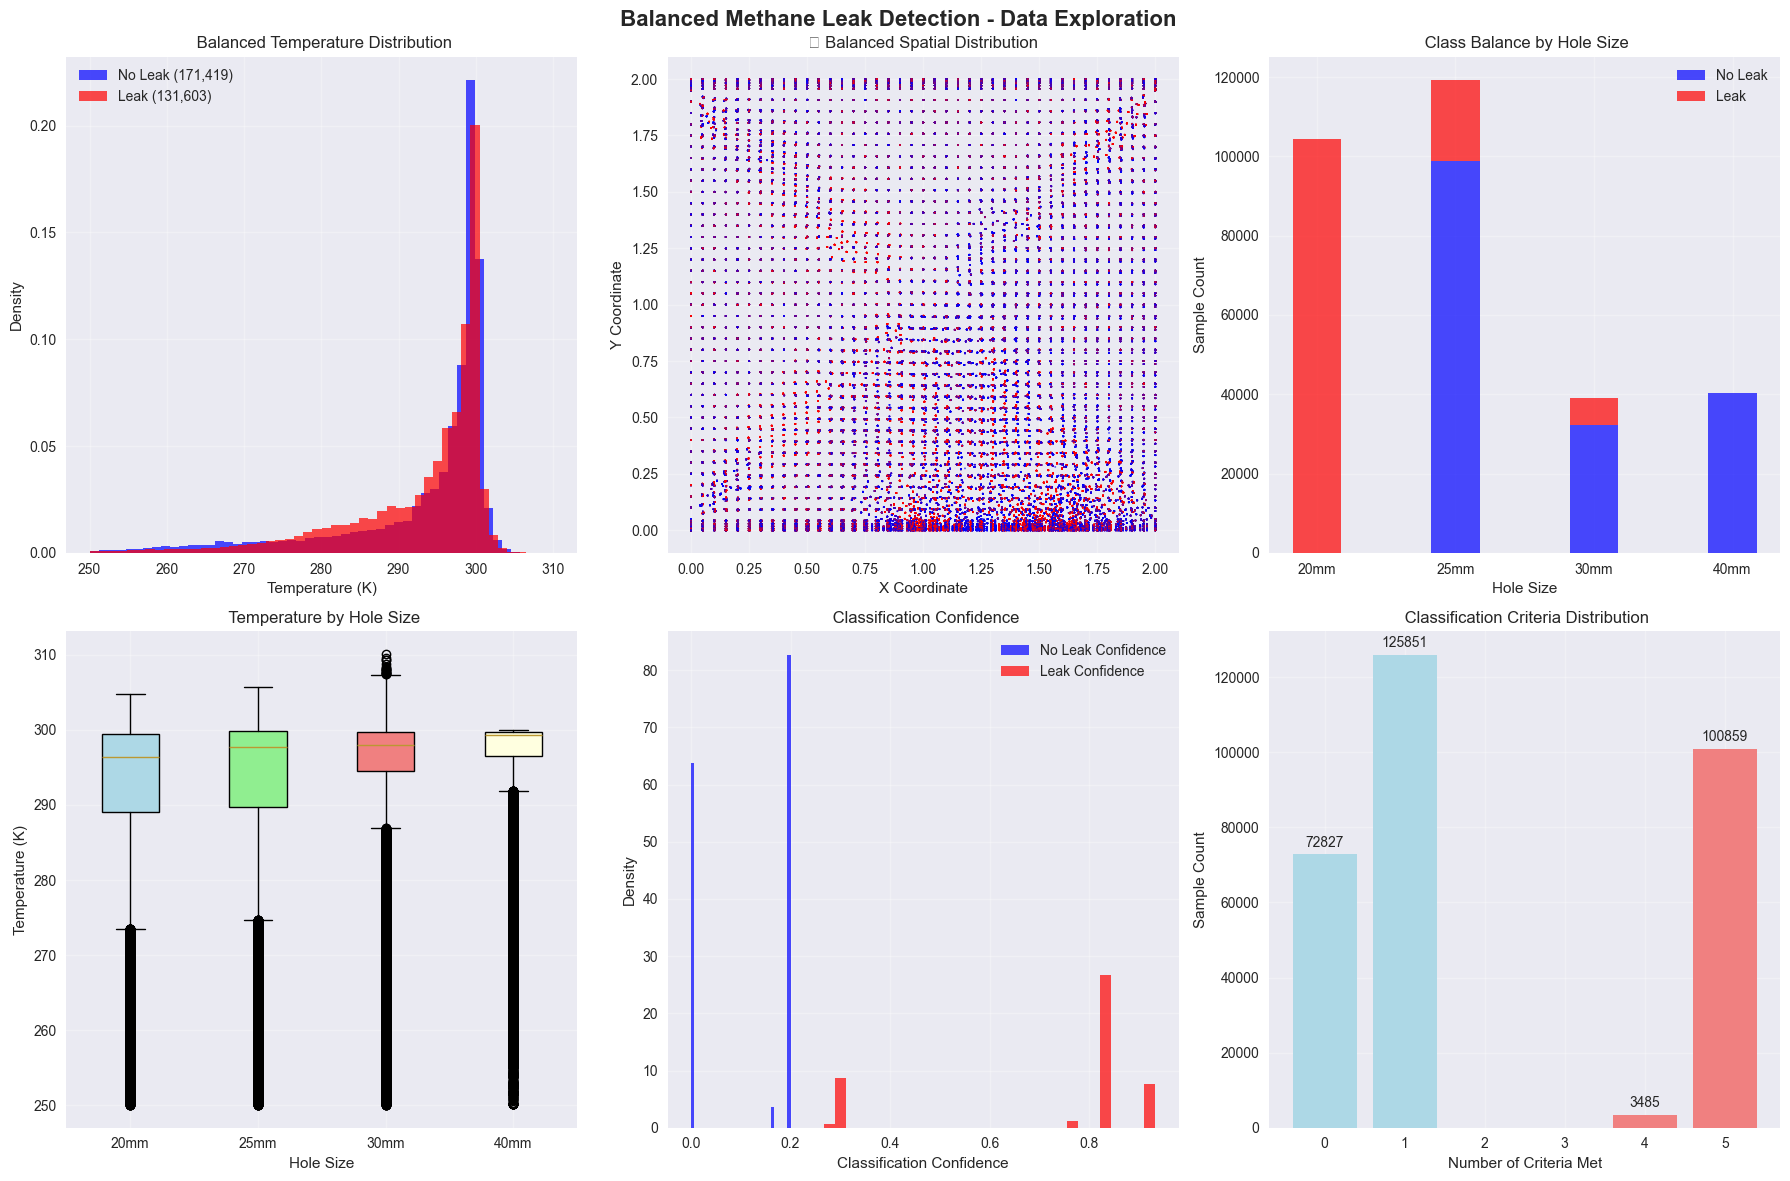


⚖️ CLASS BALANCE VERIFICATION:
 No Leak samples: 171,419 (56.6%)
 Leak samples: 131,603 (43.4%)
 Balance ratio: 43.4% (Target: 40.0%)
 Balance status: EXCELLENT

 Creating interactive 3D visualization...
📊 Showing stratified sample of 5000 points for performance


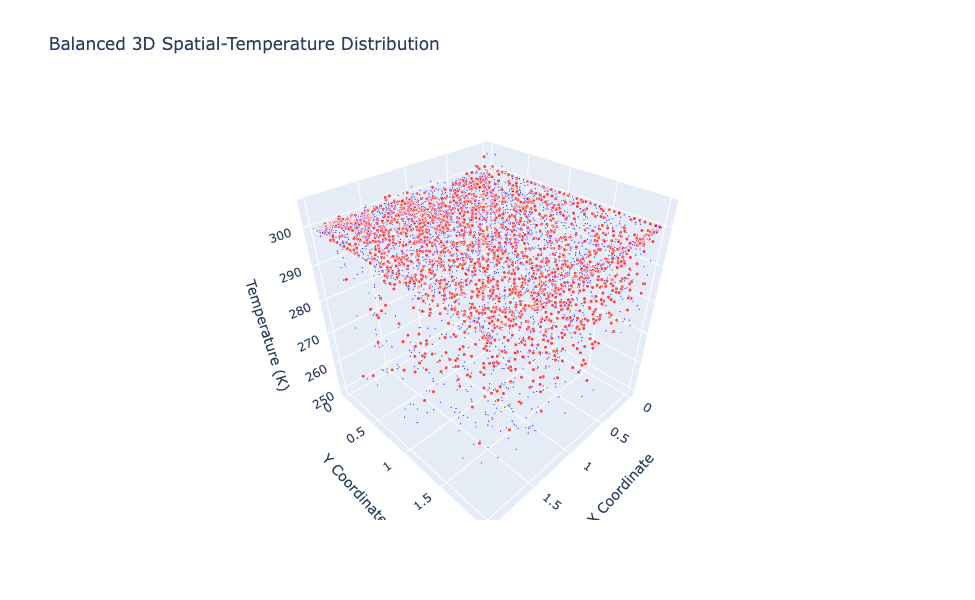

In [9]:
if not combined_df.empty:
    print(" Creating balanced data exploration visualizations...")
    
    # Set up the plotting environment
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(' Balanced Methane Leak Detection - Data Exploration', fontsize=16, fontweight='bold')
    
    # Plot 1: Temperature distribution by leak status
    ax1 = axes[0, 0]
    leak_data = combined_df[combined_df['leak_status'] == 1]['temperature']
    no_leak_data = combined_df[combined_df['leak_status'] == 0]['temperature']
    
    ax1.hist(no_leak_data, bins=50, alpha=0.7, label=f'No Leak ({len(no_leak_data):,})', color='blue', density=True)
    ax1.hist(leak_data, bins=50, alpha=0.7, label=f'Leak ({len(leak_data):,})', color='red', density=True)
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Density')
    ax1.set_title(' Balanced Temperature Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Spatial distribution
    ax2 = axes[0, 1]
    colors = ['blue' if x == 0 else 'red' for x in combined_df['leak_status']]
    scatter = ax2.scatter(combined_df['x-coordinate'], combined_df['y-coordinate'], 
                         c=colors, alpha=0.6, s=1)
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_title('📍 Balanced Spatial Distribution')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Class distribution by hole size
    ax3 = axes[0, 2]
    hole_leak_data = []
    hole_labels = []
    for hole_size in Config.HOLE_SIZES:
        if hole_size in combined_df['hole_size'].values:
            subset = combined_df[combined_df['hole_size'] == hole_size]
            leak_count = subset['leak_status'].sum()
            no_leak_count = (subset['leak_status'] == 0).sum()
            hole_leak_data.append([no_leak_count, leak_count])
            hole_labels.append(hole_size)
    
    if hole_leak_data:
        hole_array = np.array(hole_leak_data)
        x = np.arange(len(hole_labels))
        width = 0.35
        
        ax3.bar(x, hole_array[:, 0], width, label='No Leak', color='blue', alpha=0.7)
        ax3.bar(x, hole_array[:, 1], width, bottom=hole_array[:, 0], label='Leak', color='red', alpha=0.7)
        ax3.set_xlabel('Hole Size')
        ax3.set_ylabel('Sample Count')
        ax3.set_title(' Class Balance by Hole Size')
        ax3.set_xticks(x)
        ax3.set_xticklabels(hole_labels)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Temperature statistics by hole size
    ax4 = axes[1, 0]
    temp_by_hole = []
    hole_labels_temp = []
    for hole_size in Config.HOLE_SIZES:
        if hole_size in combined_df['hole_size'].values:
            temp_data = combined_df[combined_df['hole_size'] == hole_size]['temperature']
            if len(temp_data) > 0:
                temp_by_hole.append(temp_data)
                hole_labels_temp.append(hole_size)
    
    if temp_by_hole:
        bp = ax4.boxplot(temp_by_hole, labels=hole_labels_temp, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        ax4.set_xlabel('Hole Size')
        ax4.set_ylabel('Temperature (K)')
        ax4.set_title(' Temperature by Hole Size')
        ax4.grid(True, alpha=0.3)
    
    # Plot 5: Confidence distribution
    ax5 = axes[1, 1]
    leak_conf = combined_df[combined_df['leak_status'] == 1]['leak_confidence']
    no_leak_conf = combined_df[combined_df['leak_status'] == 0]['leak_confidence']
    
    ax5.hist(no_leak_conf, bins=30, alpha=0.7, label='No Leak Confidence', color='blue', density=True)
    ax5.hist(leak_conf, bins=30, alpha=0.7, label='Leak Confidence', color='red', density=True)
    ax5.set_xlabel('Classification Confidence')
    ax5.set_ylabel('Density')
    ax5.set_title(' Classification Confidence')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Criteria count distribution
    ax6 = axes[1, 2]
    criteria_counts = combined_df['criteria_count'].value_counts().sort_index()
    bars = ax6.bar(criteria_counts.index, criteria_counts.values, 
                   color=['lightcoral' if i >= 3 else 'lightblue' for i in criteria_counts.index])
    ax6.set_xlabel('Number of Criteria Met')
    ax6.set_ylabel('Sample Count')
    ax6.set_title(' Classification Criteria Distribution')
    ax6.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, criteria_counts.values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(criteria_counts.values)*0.01, 
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Class balance summary
    print(f"\n⚖️ CLASS BALANCE VERIFICATION:")
    print(f"{'='*50}")
    leak_count = combined_df['leak_status'].sum()
    total_count = len(combined_df)
    no_leak_count = total_count - leak_count
    leak_ratio = leak_count / total_count
    
    print(f" No Leak samples: {no_leak_count:,} ({(1-leak_ratio):.1%})")
    print(f" Leak samples: {leak_count:,} ({leak_ratio:.1%})")
    print(f" Balance ratio: {leak_ratio:.1%} (Target: {Config.TARGET_LEAK_RATIO:.1%})")
    
    balance_status = "EXCELLENT" if abs(leak_ratio - Config.TARGET_LEAK_RATIO) < 0.05 else "GOOD" if abs(leak_ratio - Config.TARGET_LEAK_RATIO) < 0.1 else "NEEDS IMPROVEMENT"
    print(f" Balance status: {balance_status}")
    
    # Interactive Plotly visualization
    print("\n Creating interactive 3D visualization...")
    
    # Sample data for performance if too large
    if len(combined_df) > 5000:
        # Stratified sampling to maintain balance
        leak_sample = combined_df[combined_df['leak_status'] == 1].sample(n=2000, random_state=42)
        no_leak_sample = combined_df[combined_df['leak_status'] == 0].sample(n=3000, random_state=42)
        sample_df = pd.concat([leak_sample, no_leak_sample]).sample(frac=1, random_state=42)
        print(f"📊 Showing stratified sample of 5000 points for performance")
    else:
        sample_df = combined_df
    
    colors = ['blue' if x == 0 else 'red' for x in sample_df['leak_status']]
    sizes = [4 if x == 1 else 2 for x in sample_df['leak_status']]  # Larger markers for leaks
    
    fig_3d = go.Figure(data=go.Scatter3d(
        x=sample_df['x-coordinate'],
        y=sample_df['y-coordinate'],
        z=sample_df['temperature'],
        mode='markers',
        marker=dict(
            color=colors,
            size=sizes,
            opacity=0.7
        ),
        text=[f"Status: {'🔥 Leak' if status else '✅ No Leak'}<br>Hole: {hole}<br>Confidence: {conf:.2f}<br>Criteria: {crit}" 
              for status, hole, conf, crit in zip(sample_df['leak_status'], sample_df['hole_size'], 
                                                 sample_df['leak_confidence'], sample_df['criteria_count'])],
        hovertemplate='X: %{x}<br>Y: %{y}<br>Temp: %{z:.1f}K<br>%{text}<extra></extra>'
    ))
    
    fig_3d.update_layout(
        title=' Balanced 3D Spatial-Temperature Distribution',
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Temperature (K)'
        ),
        width=800,
        height=600
    )
    
    fig_3d.show()
    
else:
    print(" No data available for visualization")

🔧 Applying comprehensive feature engineering...
 Creating thermal features...
 Creating spatial features...
   Creating interaction features...
   Creating statistical features...
 Feature engineering completed! Created 60 features

 Comprehensive Feature Engineering Results:
  Original features: 10
  Engineered features: 60
  New features added: 50
  Original leak ratio: 43.4%
  After engineering leak ratio: 43.4%

 Top 15 Features by Correlation with Leak Status:
   1. leak_confidence                : 0.879
   2. criteria_count                 : 0.843
   3. hole_size_encoded              : 0.693
   4. temp_hole_interaction          : 0.691
   5. distance_hole_interaction      : 0.602
   6. temp_percentile_rank           : 0.074
   7. is_temp_outlier                : 0.053
   8. is_cold_spot                   : 0.051
   9. temp_category_encoded          : 0.051
  10. temp_zscore_abs                : 0.049
  11. temp_per_distance              : 0.036
  12. temp_quadrant_interaction    

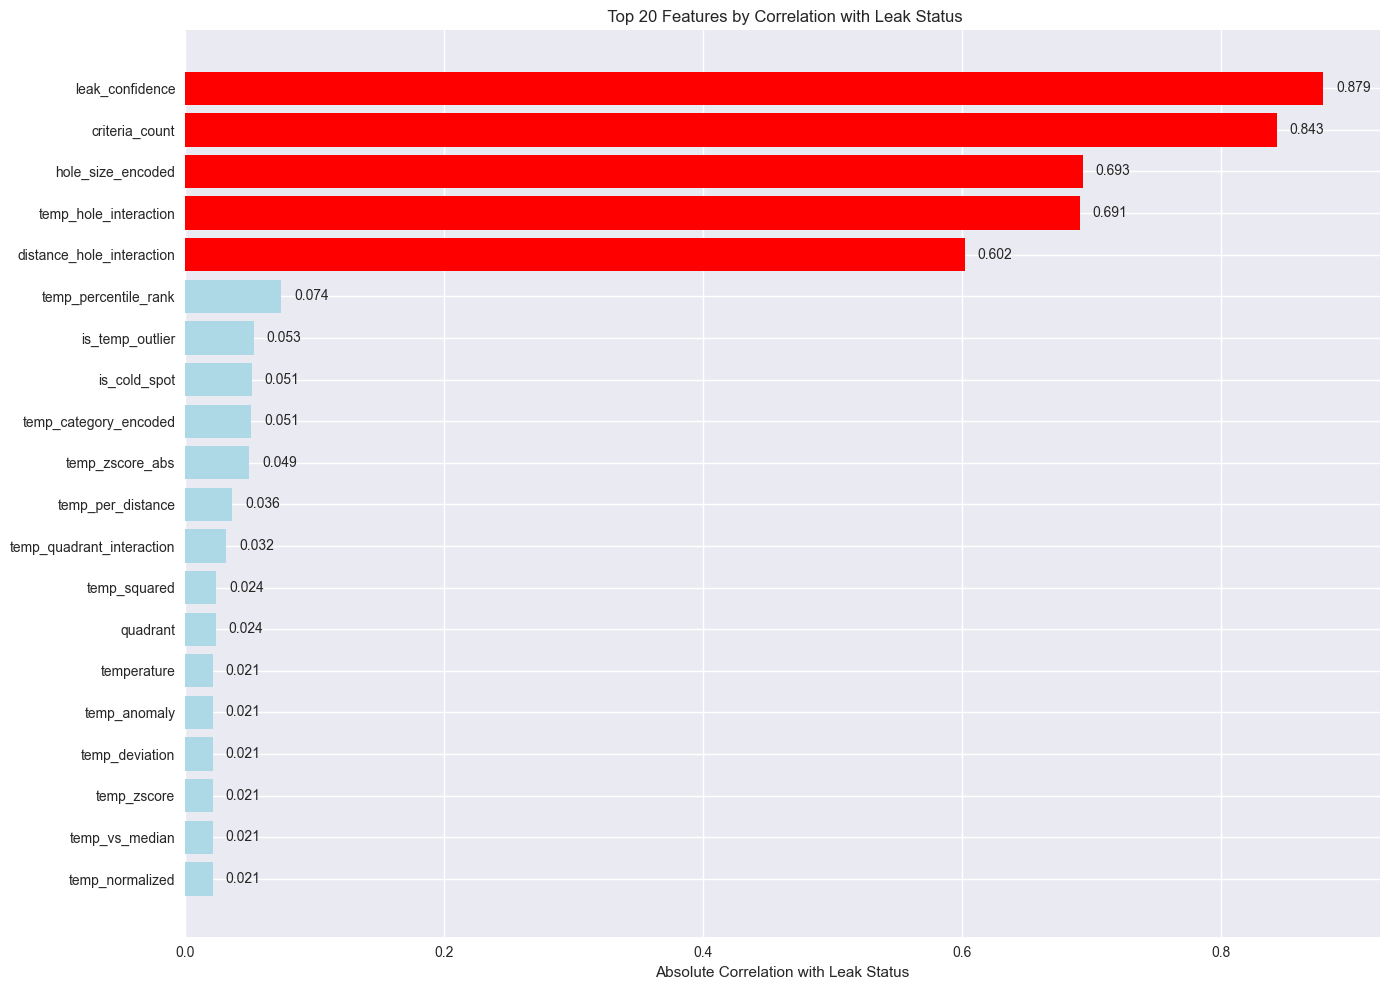


 Feature Categories Analysis:
  Category        Count    Avg Correlation    Max Correlation
  ------------------------------------------------------------
  Other           10       0.249              0.879
  Thermal         24       0.051              0.691
  Spatial         17       0.039              0.602


In [10]:
class AdvancedFeatureEngineer:
    """Comprehensive feature engineering optimized for balanced classification"""
    
    @staticmethod
    def create_thermal_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create enhanced thermal features for leak detection"""
        print(" Creating thermal features...")
        df_features = df.copy()
        
        if 'temperature' not in df_features.columns:
            return df_features
        
        # Basic thermal features
        ambient_temp = 300.0
        df_features['temp_anomaly'] = df_features['temperature'] - ambient_temp
        df_features['temp_anomaly_abs'] = np.abs(df_features['temp_anomaly'])
        df_features['temp_normalized'] = (df_features['temperature'] - ambient_temp) / ambient_temp
        df_features['temp_log'] = np.log(df_features['temperature'])
        df_features['temp_squared'] = df_features['temperature'] ** 2
        df_features['temp_sqrt'] = np.sqrt(df_features['temperature'])
        
        # Advanced thermal indicators
        df_features['temp_deviation'] = (df_features['temperature'] - df_features['temperature'].mean()) / df_features['temperature'].std()
        df_features['temp_percentile_rank'] = df_features['temperature'].rank(pct=True)
        
        # Temperature categories (more granular)
        temp_bins = [0, 285, 295, 305, 315, 325, 350, np.inf]
        temp_labels = [0, 1, 2, 3, 4, 5, 6]
        df_features['temp_category'] = pd.cut(df_features['temperature'], bins=temp_bins, labels=temp_labels)
        df_features['temp_category_encoded'] = df_features['temp_category'].astype(int)
        
        # Binary indicators (more sensitive)
        df_features['is_above_ambient'] = (df_features['temperature'] > ambient_temp + 5).astype(int)
        df_features['is_hot_spot'] = (df_features['temperature'] > ambient_temp + 15).astype(int)
        df_features['is_very_hot'] = (df_features['temperature'] > ambient_temp + 25).astype(int)
        df_features['is_extreme_hot'] = (df_features['temperature'] > ambient_temp + 40).astype(int)
        df_features['is_cold_spot'] = (df_features['temperature'] < ambient_temp - 10).astype(int)
        
        # Statistical features
        temp_median = df_features['temperature'].median()
        df_features['temp_vs_median'] = df_features['temperature'] - temp_median
        df_features['temp_vs_median_ratio'] = df_features['temperature'] / temp_median
        
        return df_features
    
    @staticmethod
    def create_spatial_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create enhanced spatial features"""
        print(" Creating spatial features...")
        if 'x-coordinate' not in df.columns or 'y-coordinate' not in df.columns:
            return df
        
        # Distance features
        df['distance_from_origin'] = np.sqrt(df['x-coordinate']**2 + df['y-coordinate']**2)
        df['manhattan_distance'] = np.abs(df['x-coordinate']) + np.abs(df['y-coordinate'])
        df['max_coordinate_distance'] = np.maximum(np.abs(df['x-coordinate']), np.abs(df['y-coordinate']))
        
        # Polar coordinates
        df['angle_rad'] = np.arctan2(df['y-coordinate'], df['x-coordinate'])
        df['angle_deg'] = np.degrees(df['angle_rad'])
        df['angle_deg_norm'] = (df['angle_deg'] + 180) / 360  # Normalize to [0,1]
        
        # Spatial zones (multiple granularities)
        for zones in [5, 10, 20]:
            df[f'x_zone_{zones}'] = pd.cut(df['x-coordinate'], bins=zones, labels=False)
            df[f'y_zone_{zones}'] = pd.cut(df['y-coordinate'], bins=zones, labels=False)
            df[f'spatial_zone_{zones}'] = df[f'x_zone_{zones}'] * zones + df[f'y_zone_{zones}']
        
        # Quadrants and octants
        df['quadrant'] = ((df['x-coordinate'] >= 0).astype(int) * 2 + 
                         (df['y-coordinate'] >= 0).astype(int))
        
        # Octants (8 directional zones)
        angle_octant = ((df['angle_deg'] + 22.5) % 360) // 45
        df['octant'] = angle_octant.astype(int)
        
        # Distance-based features
        df['is_center_region'] = (df['distance_from_origin'] < df['distance_from_origin'].quantile(0.25)).astype(int)
        df['is_edge_region'] = (df['distance_from_origin'] > df['distance_from_origin'].quantile(0.75)).astype(int)
        
        return df
    
    @staticmethod
    def create_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create interaction features between spatial and thermal"""
        print("   Creating interaction features...")
        
        if all(col in df.columns for col in ['temperature', 'distance_from_origin']):
            # Temperature-distance interactions
            df['temp_distance_product'] = df['temperature'] * df['distance_from_origin']
            df['temp_distance_ratio'] = df['temperature'] / (df['distance_from_origin'] + 1e-8)
            df['temp_per_distance'] = df['temp_anomaly'] / (df['distance_from_origin'] + 1)
        
        if all(col in df.columns for col in ['temperature', 'quadrant']):
            # Temperature by quadrant statistics
            df['temp_quadrant_interaction'] = df['temperature'] * df['quadrant']
        
        if 'hole_size_encoded' in df.columns:
            # Hole size interactions
            df['temp_hole_interaction'] = df['temperature'] * df['hole_size_encoded']
            df['distance_hole_interaction'] = df['distance_from_origin'] * df['hole_size_encoded']
        
        return df
    
    @staticmethod
    def create_statistical_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create statistical features for better leak detection"""
        print("   Creating statistical features...")
        
        # Rolling statistics (if enough data)
        if len(df) > 10:
            df_sorted = df.sort_values('temperature').reset_index(drop=True)
            window_size = min(5, len(df) // 4)
            
            df['temp_rolling_mean'] = df_sorted['temperature'].rolling(window=window_size).mean()
            df['temp_rolling_std'] = df_sorted['temperature'].rolling(window=window_size).std()
            df['temp_rolling_min'] = df_sorted['temperature'].rolling(window=window_size).min()
            df['temp_rolling_max'] = df_sorted['temperature'].rolling(window=window_size).max()
            
            # Fill NaN values
            df['temp_rolling_mean'] = df['temp_rolling_mean'].fillna(df['temperature'].mean())
            df['temp_rolling_std'] = df['temp_rolling_std'].fillna(df['temperature'].std())
            df['temp_rolling_min'] = df['temp_rolling_min'].fillna(df['temperature'].min())
            df['temp_rolling_max'] = df['temp_rolling_max'].fillna(df['temperature'].max())
        
        # Z-score features
        temp_mean = df['temperature'].mean()
        temp_std = df['temperature'].std()
        if temp_std > 0:
            df['temp_zscore'] = (df['temperature'] - temp_mean) / temp_std
            df['temp_zscore_abs'] = np.abs(df['temp_zscore'])
            df['is_temp_outlier'] = (np.abs(df['temp_zscore']) > 2).astype(int)
        else:
            df['temp_zscore'] = 0
            df['temp_zscore_abs'] = 0
            df['is_temp_outlier'] = 0
        
        return df
    
    @staticmethod
    def engineer_all_features(df: pd.DataFrame) -> pd.DataFrame:
        """Apply all feature engineering steps"""
        if df.empty:
            return df
        
        print("🔧 Applying comprehensive feature engineering...")
        df_processed = df.copy()
        
        # Step 1: Thermal features
        df_processed = AdvancedFeatureEngineer.create_thermal_features(df_processed)
        
        # Step 2: Spatial features
        df_processed = AdvancedFeatureEngineer.create_spatial_features(df_processed)
        
        # Step 3: Encode categorical variables
        if 'hole_size' in df_processed.columns:
            le_hole = LabelEncoder()
            df_processed['hole_size_encoded'] = le_hole.fit_transform(df_processed['hole_size'])
        
        # Step 4: Interaction features
        df_processed = AdvancedFeatureEngineer.create_interaction_features(df_processed)
        
        # Step 5: Statistical features
        df_processed = AdvancedFeatureEngineer.create_statistical_features(df_processed)
        
        # Handle missing values
        numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
        df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())
        
        # Remove infinite values
        df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
        df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())
        
        print(f" Feature engineering completed! Created {len(df_processed.columns)} features")
        
        return df_processed

# Apply comprehensive feature engineering
if not combined_df.empty:
    feature_engineer = AdvancedFeatureEngineer()
    df_engineered = feature_engineer.engineer_all_features(combined_df)
    
    print(f"\n Comprehensive Feature Engineering Results:")
    print(f"  Original features: {len(combined_df.columns)}")
    print(f"  Engineered features: {len(df_engineered.columns)}")
    print(f"  New features added: {len(df_engineered.columns) - len(combined_df.columns)}")
    
    # Verify balance is maintained
    original_ratio = combined_df['leak_status'].mean()
    engineered_ratio = df_engineered['leak_status'].mean()
    print(f"  Original leak ratio: {original_ratio:.1%}")
    print(f"  After engineering leak ratio: {engineered_ratio:.1%}")
    
    # Show feature correlation with target
    if 'leak_status' in df_engineered.columns:
        print("\n Top 15 Features by Correlation with Leak Status:")
        numeric_features = df_engineered.select_dtypes(include=[np.number])
        correlations = []
        
        for col in numeric_features.columns:
            if col != 'leak_status' and not col.startswith('nodenumber'):
                try:
                    corr = abs(numeric_features[col].corr(df_engineered['leak_status']))
                    if not np.isnan(corr):
                        correlations.append((col, corr))
                except:
                    continue
        
        # Sort by correlation
        correlations.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, corr) in enumerate(correlations[:15], 1):
            print(f"  {i:2d}. {feature:<30} : {corr:.3f}")
        
        # Plot feature correlations
        plt.figure(figsize=(14, 10))
        top_features = [feat for feat, _ in correlations[:20]]
        top_corrs = [corr for _, corr in correlations[:20]]
        
        # Create color map based on correlation strength
        colors = ['red' if corr > 0.3 else 'orange' if corr > 0.2 else 'yellow' if corr > 0.1 else 'lightblue' for corr in top_corrs]
        
        bars = plt.barh(top_features, top_corrs, color=colors)
        plt.xlabel('Absolute Correlation with Leak Status')
        plt.title(' Top 20 Features by Correlation with Leak Status')
        plt.gca().invert_yaxis()
        
        # Add correlation values as text
        for bar, corr in zip(bars, top_corrs):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{corr:.3f}', ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance analysis
        print(f"\n Feature Categories Analysis:")
        category_stats = {}
        for feature, corr in correlations:
            if 'temp' in feature.lower():
                category = 'Thermal'
            elif any(spatial in feature.lower() for spatial in ['x_', 'y_', 'distance', 'angle', 'quadrant', 'zone', 'spatial']):
                category = 'Spatial'
            elif 'interaction' in feature.lower():
                category = 'Interaction'
            elif any(stat in feature.lower() for stat in ['rolling', 'zscore', 'percentile', 'std']):
                category = 'Statistical'
            else:
                category = 'Other'
            
            if category not in category_stats:
                category_stats[category] = []
            category_stats[category].append(corr)
        
        print(f"  {'Category':<15} {'Count':<8} {'Avg Correlation':<18} {'Max Correlation'}")
        print(f"  {'-'*60}")
        for category, corrs in category_stats.items():
            avg_corr = np.mean(corrs)
            max_corr = np.max(corrs)
            count = len(corrs)
            print(f"  {category:<15} {count:<8} {avg_corr:<18.3f} {max_corr:.3f}")

In [11]:
class BalancedModelTrainer:
    """Advanced model trainer optimized for balanced datasets"""
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.results = {}
        self.best_model = None
        self.feature_names = []
        
    def prepare_balanced_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        """Advanced data preparation for balanced classification"""
        print(" Preparing balanced dataset...")
        
        # Separate features and target
        target_col = 'leak_status'
        exclude_cols = [
            target_col, 'hole_size', 'file_name', 'nodenumber', 
            'classification_method', 'temp_category'  # Exclude categorical
        ]
        
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
        
        X = df[numeric_cols].copy()
        y = df[target_col].copy()
        
        print(f"  Features before filtering: {len(numeric_cols)}")
        
        # Handle missing values
        X = X.fillna(X.median())
        
        # Remove features with too many missing values or no variance
        # Remove columns with all NaN or infinite values
        X = X.loc[:, ~X.isin([np.nan, np.inf, -np.inf]).all()]
        
        # Remove low variance features
        variance_selector = VarianceThreshold(threshold=0.001)  # Lower threshold
        X_filtered = variance_selector.fit_transform(X)
        selected_features = X.columns[variance_selector.get_support()].tolist()
        
        X_final = pd.DataFrame(X_filtered, columns=selected_features, index=X.index)
        
        # Additional correlation-based feature selection
        if len(selected_features) > 50:  # Only if we have many features
            correlations = []
            for col in selected_features:
                if col != target_col:
                    corr = abs(X_final[col].corr(y))
                    if not np.isnan(corr):
                        correlations.append((col, corr))
            
            # Keep top features by correlation
            correlations.sort(key=lambda x: x[1], reverse=True)
            top_features = [feat for feat, _ in correlations[:min(40, len(correlations))]]
            X_final = X_final[top_features]
            selected_features = top_features
        
        self.feature_names = selected_features
        
        # Verify balance
        class_counts = y.value_counts().sort_index()
        print(f"  Class distribution: {dict(class_counts)}")
        print(f"  Leak ratio: {y.mean():.1%}")
        print(f"  Final features: {len(selected_features)}")
        
        return X_final.values, y.values, selected_features
    
    def create_balanced_models(self):
        """Create model configurations optimized for balanced data"""
        return {
            'BalancedRandomForest': {
                'model': RandomForestClassifier(
                    n_estimators=150, 
                    random_state=Config.RANDOM_STATE, 
                    n_jobs=-1,
                    class_weight='balanced',
                    max_depth=15
                ),
                'params': {
                    'max_depth': [10, 15, 20], 
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'BalancedGradientBoosting': {
                'model': GradientBoostingClassifier(
                    n_estimators=150, 
                    random_state=Config.RANDOM_STATE,
                    learning_rate=0.1
                ),
                'params': {
                    'learning_rate': [0.05, 0.1, 0.15], 
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 0.9, 1.0]
                }
            },
            'BalancedSVM': {
                'model': SVC(
                    probability=True, 
                    random_state=Config.RANDOM_STATE,
                    class_weight='balanced'
                ),
                'params': {
                    'C': [0.1, 1, 10, 100], 
                    'kernel': ['rbf', 'poly'],
                    'gamma': ['scale', 'auto']
                }
            },
            'BalancedLogisticRegression': {
                'model': LogisticRegression(
                    random_state=Config.RANDOM_STATE, 
                    max_iter=2000,
                    class_weight='balanced'
                ),
                'params': {
                    'C': [0.01, 0.1, 1, 10, 100],
                    'solver': ['liblinear', 'lbfgs']
                }
            },
            'BalancedExtraTrees': {
                'model': ExtraTreesClassifier(
                    n_estimators=150,
                    random_state=Config.RANDOM_STATE,
                    n_jobs=-1,
                    class_weight='balanced'
                ),
                'params': {
                    'max_depth': [10, 15, 20],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                }
            }
        }
    
    def train_all_models(self, X_train, X_val, y_train, y_val, feature_names):
        """Train all models with balanced scoring"""
        print(" Training balanced ML models...")
        
        models_config = self.create_balanced_models()
        
        for i, (name, config) in enumerate(models_config.items()):
            print(f"   Training {name}...")
            
            start_time = time.time()
            
            # Scale data for certain models
            if 'SVM' in name or 'LogisticRegression' in name:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                self.scalers[name] = scaler
            else:
                X_train_scaled = X_train
                X_val_scaled = X_val
                self.scalers[name] = None
            
            # Stratified cross-validation with balanced scoring
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=Config.RANDOM_STATE)
            
            # Use balanced accuracy as primary metric
            grid_search = GridSearchCV(
                config['model'], 
                config['params'], 
                cv=cv, 
                scoring='balanced_accuracy',  # Better for balanced datasets
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(X_train_scaled, y_train)
            training_time = time.time() - start_time
            
            # Predictions
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_val_scaled)
            y_proba = best_model.predict_proba(X_val_scaled)[:, 1]
            
            # Comprehensive metrics
            self.models[name] = best_model
            self.results[name] = {
                'accuracy': accuracy_score(y_val, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_val, y_pred),
                'roc_auc': roc_auc_score(y_val, y_proba),
                'f1_score': f1_score(y_val, y_pred),
                'precision': precision_score(y_val, y_pred),
                'recall': recall_score(y_val, y_pred),
                'training_time': training_time,
                'best_params': grid_search.best_params_,
                'best_cv_score': grid_search.best_score_,
                'y_pred': y_pred,
                'y_proba': y_proba
            }
            
            print(f" {name}:")
            print(f"       Accuracy: {self.results[name]['accuracy']:.3f}")
            print(f"       Balanced Accuracy: {self.results[name]['balanced_accuracy']:.3f}")
            print(f"       ROC-AUC: {self.results[name]['roc_auc']:.3f}")
            print(f"       F1-Score: {self.results[name]['f1_score']:.3f}")
            print(f"       Time: {training_time:.1f}s")
        
        # Find best model based on balanced accuracy
        self.best_model = max(self.results, key=lambda x: self.results[x]['balanced_accuracy'])
        
        print(f"\n Best model: {self.best_model}")
        print(f"   Balanced Accuracy: {self.results[self.best_model]['balanced_accuracy']:.3f}")
        print(f"   ROC-AUC: {self.results[self.best_model]['roc_auc']:.3f}")
        print(f"   F1-Score: {self.results[self.best_model]['f1_score']:.3f}")
        
        return self.results
    
    def evaluate_on_test_set(self, X_test, y_test):
        """Comprehensive evaluation on test set"""
        print(f" Evaluating {self.best_model} on test set...")
        
        best_model = self.models[self.best_model]
        scaler = self.scalers.get(self.best_model)
        
        if scaler:
            X_test_scaled = scaler.transform(X_test)
        else:
            X_test_scaled = X_test
        
        y_pred = best_model.predict(X_test_scaled)
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'f1_score': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'y_pred': y_pred,
            'y_proba': y_proba
        }

# Train balanced models if data is available
if not df_engineered.empty:
    print("\n" + "="*70)
    print(" STARTING BALANCED MODEL TRAINING")
    print("="*70)
    
    # Initialize balanced trainer
    trainer = BalancedModelTrainer()
    
    # Prepare balanced data
    X, y, feature_names = trainer.prepare_balanced_data(df_engineered)
    
    print(f"\n Balanced Dataset Summary:")
    print(f"  Total samples: {len(X):,}")
    print(f"  Selected features: {len(feature_names)}")
    leak_count = y.sum()
    no_leak_count = len(y) - leak_count
    print(f"  Leak samples: {leak_count:,} ({y.mean():.1%})")
    print(f"  No-leak samples: {no_leak_count:,} ({(1-y.mean()):.1%})")
    
    # Stratified split to maintain balance
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=Config.RANDOM_STATE, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=Config.RANDOM_STATE, stratify=y_temp
    )
    
    # Verify balance in splits
    print(f"\n Split Balance Verification:")
    print(f"  Training: {len(X_train):,} samples, {y_train.mean():.1%} leak")
    print(f"  Validation: {len(X_val):,} samples, {y_val.mean():.1%} leak")
    print(f"  Test: {len(X_test):,} samples, {y_test.mean():.1%} leak")
    
    # Train models
    results = trainer.train_all_models(X_train, X_val, y_train, y_val, feature_names)
    
    # Display comprehensive results
    print(f"\n BALANCED MODEL TRAINING RESULTS:")
    print("-" * 100)
    print(f"{'Model':<25} {'Accuracy':<10} {'Bal_Acc':<10} {'ROC-AUC':<10} {'F1-Score':<10} {'Precision':<10} {'Recall':<10} {'Time(s)':<8}")
    print("-" * 100)
    
    for model_name, result in results.items():
        print(f"{model_name:<25} {result['accuracy']:<10.3f} {result['balanced_accuracy']:<10.3f} "
              f"{result['roc_auc']:<10.3f} {result['f1_score']:<10.3f} {result['precision']:<10.3f} "
              f"{result['recall']:<10.3f} {result['training_time']:<8.1f}")
    
    print("-" * 100)
    print(f" Best Model: {trainer.best_model} (Balanced Accuracy: {results[trainer.best_model]['balanced_accuracy']:.3f})")
    
else:
    print("No engineered data available for training")


 STARTING BALANCED MODEL TRAINING
 Preparing balanced dataset...
  Features before filtering: 54
  Class distribution: {0: 171419, 1: 131603}
  Leak ratio: 43.4%
  Final features: 50

 Balanced Dataset Summary:
  Total samples: 303,022
  Selected features: 50
  Leak samples: 131,603 (43.4%)
  No-leak samples: 171,419 (56.6%)

 Split Balance Verification:
  Training: 212,115 samples, 43.4% leak
  Validation: 45,453 samples, 43.4% leak
  Test: 45,454 samples, 43.4% leak
 Training balanced ML models...
   Training BalancedRandomForest...
 BalancedRandomForest:
       Accuracy: 1.000
       Balanced Accuracy: 1.000
       ROC-AUC: 1.000
       F1-Score: 1.000
       Time: 1271.5s
   Training BalancedGradientBoosting...
 BalancedGradientBoosting:
       Accuracy: 1.000
       Balanced Accuracy: 1.000
       ROC-AUC: 1.000
       F1-Score: 1.000
       Time: 5593.7s
   Training BalancedSVM...
 BalancedSVM:
       Accuracy: 1.000
       Balanced Accuracy: 1.000
       ROC-AUC: 1.000
       F